# Logistic Regression

Supervised machine learning to classify a bivariate categorical target variable.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

This data contains information about the characteristics of Penguins collected by Dr. Kristen Gorman in the Palmer station in Antartica (https://github.com/allisonhorst/palmerpenguins/tree/main).

In [2]:
#load the data
df = pd.read_csv("https://raw.githubusercontent.com/dswede43/ML-methods/main/data/palmerpenguins.csv")
df = df.dropna() #remove NA values
df = df.reset_index(drop = True) #reset the index
df = df.apply(lambda x: pd.factorize(x)[0]) #convert categorical variables into binary

## Objective
Create a logistic regression ML model to classify the sex of a penguin.

## Train and test data splitting

In [3]:
#function to split the data into folds for cross-validation
def k_folds_split(df, k):
    #test set size
    test_size = len(df) // k
    
    #data frame indices
    df_idx = list(range(len(df))) #all indices
    unsampled_idx = df_idx #unsampled indices
    
    #split training and testing sets
    train_test_sets = []
    for _ in range(k):
        test_idx = random.sample(unsampled_idx, test_size) #test set indices
        train_idx = [x for x in df_idx if x not in test_idx] #train set indices
        unsampled_idx = [x for x in unsampled_idx if x not in test_idx] #update unsampled indices
        
        #create test and train sets based on indices
        test_df = df.iloc[test_idx]
        train_df = df.iloc[train_idx]
        train_test_sets.append([test_df, train_df])
        
    return train_test_sets

In [4]:
#split the data into folds for cross-validation
random.seed(42) #set seed
k = 10 #number of folds
train_test_sets = k_folds_split(df, k)

#look at the first set of test and train data
test_set = train_test_sets[0][0]
test_set = sm.add_constant(test_set) #add column of 1 for constants
train_set = train_test_sets[0][1]
train_set = sm.add_constant(train_set) #add column of 1 for constants

## Model selection

Model selection using an initial set of train and test data to create the different logistic regression models that will be performance tested using 10-fold cross validation.

### Full additive model

Model including all feature variables:

$$logit(sex)=\beta_{0}+\beta_{1}species+\beta_{2}island+\beta_{3}billlength+\beta_{4}billdepth+\beta_{5}flipperlength+\beta_{6}bodymass+\epsilon$$

In [5]:
#define the model formula
model_formula = 'sex ~ species + island + bill_length_mm + bill_depth_mm + flipper_length_mm + body_mass_g'

#train the data using logisitic regression
full_add_model = smf.logit(formula = model_formula, data = train_set).fit()
full_add_model.summary()

Optimization terminated successfully.
         Current function value: 0.631288
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  300
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            6
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                 0.08913
Time:                        09:25:31   Log-Likelihood:                -189.39
converged:                       True   LL-Null:                       -207.92
Covariance Type:            nonrobust   LLR p-value:                 1.713e-06
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3350      0.380      0.881      0.378      -0.410       1.080
species               0.4856      0.282      1.724      0.085      -0.066       1.038
island               -0.0788      0.214     -0.369      0.712      -0.498       0.340
bill_length_mm       -0.0139      0.005     -2.675      0.007      -0.024      -0.004
bill_depth_mm         0.0411      0.009      4.677      0.000       0.024       0.058
flipper_length_mm    -0.0309      0.013     -2.410      0.016      -0.056      -0.006
body_mass_g          -0.0109      0.007     -1.638      0.101      -0.024       0.002
=====================================================================================
"""

#### Checking for multicollinearity

In [6]:
#function to calculate VIF scores
def vif_scores(X_train):
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(X_train.values, X) for X in range(X_train.shape[1])]
    vif['feature'] = X_train.columns
    
    return vif

In [7]:
#define the feature variables
features = ['species',
            'island',
            'bill_length_mm',
            'bill_depth_mm',
            'flipper_length_mm',
            'body_mass_g']

#calculate the VIF scores for each feature
vif = vif_scores(train_set[features])
vif

,vif,feature
0,5.241273,species
1,3.250769,island
2,11.867773,bill_length_mm
3,6.543099,bill_depth_mm
4,7.249836,flipper_length_mm
5,5.327354,body_mass_g


The features *bill_length_mm* and *flipper_length_mm* show evidence of multicollinearity given their high VIF scores.

In [8]:
#define the feature variables
features = ['species',
            'island',
            'bill_depth_mm',
            'body_mass_g']

#calculate the VIF scores for each feature
vif = vif_scores(train_set[features])
vif

,vif,feature
0,2.887494,species
1,2.964468,island
2,4.715387,bill_depth_mm
3,3.736665,body_mass_g


The VIF scores are now below 5; therefore, there is no longer any issues with multicollinearity among feature variables.

### Reduced additive model 1

Model with collinear feature variables removed.

$$logit(sex)=\beta_{0}+\beta_{1}species+\beta_{2}island+\beta_{3}billdepth+\beta_{4}bodymass+\epsilon$$

In [9]:
#define the model formula
model_formula = 'sex ~ species + island + bill_depth_mm + body_mass_g'

#train the data using logisitic regression
red_add_model1 = smf.logit(formula = model_formula, data = train_set).fit()
red_add_model1.summary()

Optimization terminated successfully.
         Current function value: 0.657444
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  300
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                 0.05139
Time:                        09:25:31   Log-Likelihood:                -197.23
converged:                       True   LL-Null:                       -207.92
Covariance Type:            nonrobust   LLR p-value:                 0.0002676
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0282      0.360     -0.078      0.937      -0.733       0.677
species          -0.1600      0.190     -0.844      0.399      -0.532       0.212
island           -0.0406      0.208     -0.195      0.845      -0.448       0.367
bill_depth_mm     0.0276      0.008      3.626      0.000       0.013       0.042
body_mass_g      -0.0231      0.006     -3.921      0.000      -0.035      -0.012
=================================================================================
"""

The features *species* and *island* are non-significant and therefore removed.

### Reduced additive model 2

Model with non-significant feature variables removed.

$$logit(sex)=\beta_{0}+\beta_{1}billdepth+\beta_{2}bodymass+\epsilon$$

In [10]:
#define the model formula
model_formula = 'sex ~ bill_depth_mm + body_mass_g'

#train the data using logisitic regression
red_add_model2 = smf.logit(formula = model_formula, data = train_set).fit()
red_add_model2.summary()

Optimization terminated successfully.
         Current function value: 0.659409
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  300
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            2
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                 0.04855
Time:                        09:25:31   Log-Likelihood:                -197.82
converged:                       True   LL-Null:                       -207.92
Covariance Type:            nonrobust   LLR p-value:                 4.130e-05
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1462      0.240     -0.609      0.543      -0.617       0.325
bill_depth_mm     0.0258      0.007      3.586      0.000       0.012       0.040
body_mass_g      -0.0229      0.006     -3.935      0.000      -0.034      -0.012
=================================================================================
"""

### Interaction model

Model with interaction terms.

$$logit(sex)=\beta_{0}+\beta_{1}billdepth+\beta_{2}bodymass+\beta_{3}billdepth*bodymass+\epsilon$$

In [11]:
#define the model formula
model_formula = 'sex ~ bill_depth_mm + body_mass_g + bill_depth_mm:body_mass_g'

#train the data using logisitic regression
inter_model = smf.logit(formula = model_formula, data = train_set).fit()
inter_model.summary()

Optimization terminated successfully.
         Current function value: 0.659308
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  300
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            3
Date:                Sat, 02 Mar 2024   Pseudo R-squ.:                 0.04870
Time:                        09:25:31   Log-Likelihood:                -197.79
converged:                       True   LL-Null:                       -207.92
Covariance Type:            nonrobust   LLR p-value:                 0.0001506
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.2151      0.369     -0.583      0.560      -0.938       0.508
bill_depth_mm                 0.0280      0.011      2.470      0.014       0.006       0.050
body_mass_g                  -0.0203      0.012     -1.664      0.096      -0.044       0.004
bill_depth_mm:body_mass_g -6.366e-05      0.000     -0.247      0.805      -0.001       0.000
=============================================================================================
"""

## 10-Fold cross-validation

The different models to test are:

1. full additive model
2. reduced additive model 1
3. reduced additive model 2
4. interaction model

In [12]:
#define the target variable
target = 'sex'

#define the model formula
model_formulas = ['sex ~ species + island + bill_length_mm + bill_depth_mm + flipper_length_mm + body_mass_g',
                  'sex ~ species + island + bill_depth_mm + body_mass_g',
                  'sex ~ bill_depth_mm + body_mass_g',
                  'sex ~ bill_depth_mm + body_mass_g + bill_depth_mm:body_mass_g']

#perform cross-validation
model_accuracy = {}
for model_formula in model_formulas:
    fold_accuracy = []
    for i in range(len(train_test_sets)):
        #define train and test datasets
        test_set = train_test_sets[i][0]
        y_test = test_set[target]
        train_set = train_test_sets[i][1]
        
        #train the data using logistic regression
        model = smf.logit(formula = model_formula, data = train_set).fit(disp = 0)
        
        #make predictions using the model
        y_pred = model.predict(test_set)
        y_pred = (y_pred >= 0.5).astype(int)

        #test the accuracy of model predictions
        fold_accuracy.append(accuracy_score(y_test, y_pred))
    
    #store the accuracy results
    model_accuracy[model_formula] = fold_accuracy

#display model accuracy scores for each fold
model_accuracy = pd.DataFrame(model_accuracy)
model_accuracy.columns = ['full_add_model','red_add_model1','red_add_model2','inter_model']
model_accuracy

,full_add_model,red_add_model1,red_add_model2,inter_model
0,0.515152,0.424242,0.424242,0.424242
1,0.575758,0.727273,0.696970,0.787879
2,0.727273,0.696970,0.727273,0.666667
3,0.575758,0.575758,0.606061,0.606061
4,0.575758,0.636364,0.666667,0.636364
5,0.636364,0.454545,0.515152,0.484848
6,0.484848,0.515152,0.515152,0.545455
7,0.757576,0.666667,0.666667,0.666667
8,0.575758,0.575758,0.606061,0.606061
9,0.424242,0.545455,0.636364,0.666667


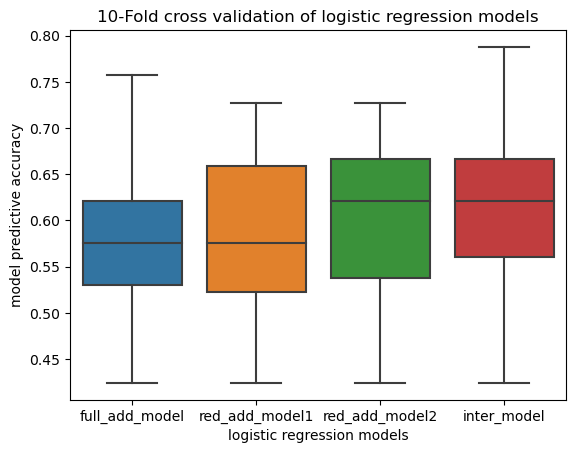

In [13]:
#display the accuracy scores for each model
sns.boxplot(model_accuracy)
plt.ylabel('model predictive accuracy')
plt.xlabel('logistic regression models')
plt.title('10-Fold cross validation of logistic regression models')
plt.show()

In [14]:
#calculate the CV scores for each model
CV_results = model_accuracy.mean()
CV_results

full_add_model    0.584848
red_add_model1    0.581818
red_add_model2    0.606061
inter_model       0.609091
dtype: float64

Based on the 10-fold cross validation accuracy scores, the *reduced additive model 2* and *interaction model* performed the best. Both models showed comparable performance but the simpler model is the *reduced additive model 2* and will therefore be used as the final model to classify penguin sex.

$$logit(sex)=-0.1462+0.0258billdepth+0.0229bodymass+\epsilon$$

## Checking final model assumptions

1. Binary response variable: Sex is either male or female.
2. Independence: Observations were measured independently for each individual penguin.
3. No multicollinearity among features: Collinear features were removed.
4. Linear relationship between features and logit of target variable: Shown below are the linear relationships for both feature variables.

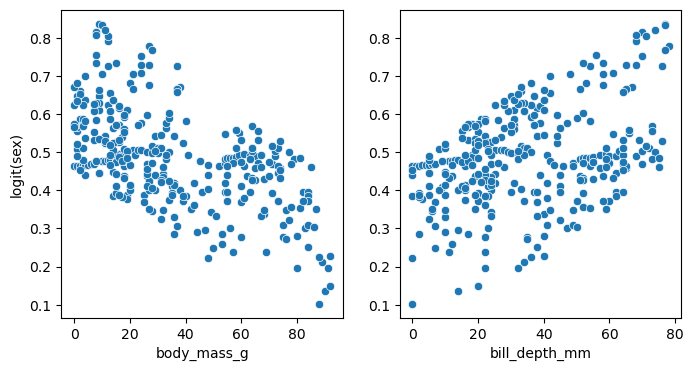

In [15]:
#calculate the log odds of the target variable
log_odds = red_add_model2.predict(df)

#define the subplot dimensions
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))

#subplot 1
sns.scatterplot(x = 'body_mass_g', y = log_odds, data = df, ax = ax1)
ax1.set_ylabel('logit(sex)')

#subplot 2
sns.scatterplot(x = 'bill_depth_mm', y = log_odds, data = df, ax = ax2)

plt.show()

The final model satifies all assumptions of logistic regression.

## Conclusion

The average cross-validation accuracy of the final model was 60.61%. More feature variables are needed to improve the predictive accuracy of this model to classify penguin sex.